### Figure 4: QQ plot

In [1]:
import numpy as np
from libpysal.weights import lat2W
import seaborn as sns
import matplotlib.pyplot as plt
import xesmf as xe
from utils.data import load_tc_data
# sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius

  return mask

In [3]:
model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)

# load datasets
real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_vaegan_ensemble,pred_gan_ensemble,meta = load_tc_data(set='validation',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')
# inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
inputs_hr_x = regridder(inputs_x)
hrmip_hr = regridder(hrmip)


(16253, 10, 10)


/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [12]:
def calc_ensemble_percentile(ensemble,analysis,percentiles,inputs_hr):
	ensemble_p=np.zeros((20,len(percentiles)))
	print(ensemble.shape)
	for i in range(20):
		if analysis == 'Mean' or analysis == 'Mean (extremes)':
			p = np.percentile(np.mean(np.mean(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Peak' or analysis == 'Peak (extremes)':
			p = np.percentile(np.max(np.max(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Everything' or analysis == 'Everything (extremes)':
			p = np.percentile(ensemble[:,:,:,i], percentiles)
		elif analysis == 'Core' or analysis == 'Core (extremes)':
			mask=radMask((25,25),25,inputs_hr[0,:,:])
			n,_,_ = inputs_hr.shape
			mask = np.expand_dims(mask,axis=0)
			mask = np.repeat(mask,n,axis=0)
			p = np.percentile(np.ma.array(ensemble[:,:,:,i], mask=mask), percentiles)
		ensemble_p[i] = p
	ensemble_mean = np.mean(ensemble_p,axis=0)
	ensemble_std = np.std(ensemble_p,axis=0)
	# ensemble_min = ensemble_mean-ensemble_std
	# ensemble_max = ensemble_mean+ensemble_std
	ensemble_min = np.min(ensemble_p,axis=0)
	ensemble_max = np.max(ensemble_p,axis=0)
	print('ensemble min is: ',ensemble_min.shape)
	return ensemble_mean,ensemble_min,ensemble_max

		

(16253, 100, 100, 20)
ensemble min is:  (10000,)
(16253, 100, 100, 20)
ensemble min is:  (10000,)
(16253, 100, 100, 20)
ensemble min is:  (10000,)
(16253, 100, 100, 20)
ensemble min is:  (10000,)
(16253, 100, 100, 20)
ensemble min is:  (10000,)
(16253, 100, 100, 20)
ensemble min is:  (10000,)
(100, 100)
(16253, 100, 100, 20)
ensemble min is:  (10000,)
(16253, 100, 100, 20)
ensemble min is:  (10000,)
(5425, 100, 100, 20)
ensemble min is:  (10000,)
(5425, 100, 100, 20)
ensemble min is:  (10000,)
(5425, 100, 100, 20)
ensemble min is:  (10000,)
(5425, 100, 100, 20)
ensemble min is:  (10000,)
(5425, 100, 100, 20)
ensemble min is:  (10000,)
(5425, 100, 100, 20)
ensemble min is:  (10000,)
(100, 100)
(5425, 100, 100, 20)
ensemble min is:  (10000,)
(5425, 100, 100, 20)
ensemble min is:  (10000,)


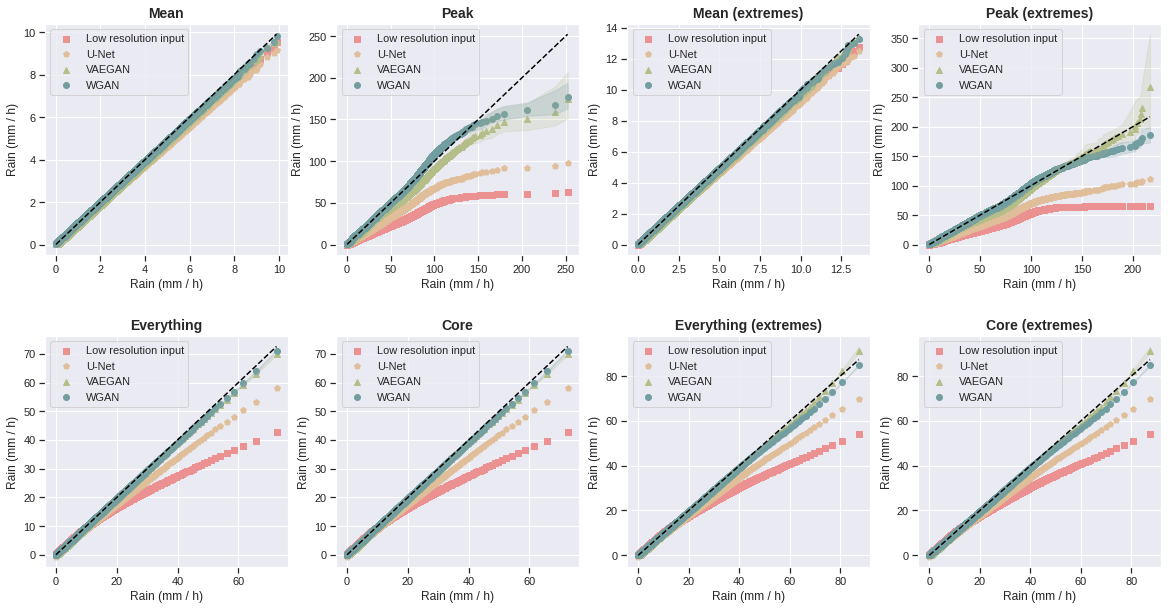

In [13]:

analysis = 'everything'

def plot_qq(ax,analysis,inputs_hr,pred_cnn,pred_vaegan,pred_dsrnngan,real,pred_vaegan_ensemble,pred_gan_ensemble,cnn=False):
	percentiles = np.arange(0,100,0.01)

	if analysis == 'Mean' or analysis == 'Mean (extremes)':
		inputs_p = np.percentile(np.mean(np.mean(inputs_hr,axis=1),axis=1), percentiles)
		unet_p = np.percentile(np.mean(np.mean(pred_cnn,axis=1),axis=1), percentiles)
		# vaegan_p = np.percentile(np.mean(np.mean(pred_vaegan,axis=1),axis=1), percentiles)
		# dsrnngan_p = np.percentile(np.mean(np.mean(pred_dsrnngan,axis=1),axis=1), percentiles)
		vaegan_p,vaegan_min,vaegan_max = calc_ensemble_percentile(pred_vaegan_ensemble,analysis,percentiles,inputs_hr)
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred_gan_ensemble,analysis,percentiles,inputs_hr)
		real_p = np.percentile(np.mean(np.mean(real,axis=1),axis=1), percentiles)

	elif analysis == 'Peak' or analysis == 'Peak (extremes)':
		inputs_p = np.percentile(np.max(np.max(inputs_hr,axis=1),axis=1), percentiles)
		unet_p = np.percentile(np.max(np.max(pred_cnn,axis=1),axis=1), percentiles)
		# vaegan_p = np.percentile(np.max(np.max(pred_vaegan,axis=1),axis=1), percentiles)
		# dsrnngan_p = np.percentile(np.max(np.max(pred_dsrnngan,axis=1),axis=1), percentiles)
		vaegan_p,vaegan_min,vaegan_max = calc_ensemble_percentile(pred_vaegan_ensemble,analysis,percentiles,inputs_hr)
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred_gan_ensemble,analysis,percentiles,inputs_hr)
		real_p = np.percentile(np.max(np.max(real,axis=1),axis=1), percentiles)

	elif analysis == 'Everything' or analysis == 'Everything (extremes)':
		inputs_p = np.percentile(inputs_hr, percentiles)
		unet_p = np.percentile(pred_cnn, percentiles)
		# vaegan_p = np.percentile(pred_vaegan, percentiles)
		# dsrnngan_p = np.percentile(pred_dsrnngan, percentiles)
		vaegan_p,vaegan_min,vaegan_max = calc_ensemble_percentile(pred_vaegan_ensemble,analysis,percentiles,inputs_hr)
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred_gan_ensemble,analysis,percentiles,inputs_hr)
		real_p = np.percentile(real, percentiles)

	elif analysis == 'Core' or analysis == 'Core (extremes)':
		print(inputs_hr[0].shape)
		mask=radMask((25,25),25,inputs_hr[0,:,:])
		n,_,_ = inputs_hr.shape
		mask = np.expand_dims(mask,axis=0)
		mask = np.repeat(mask,n,axis=0)
		inputs_hr = np.ma.array(inputs_hr, mask=mask)

		inputs_p = np.percentile(np.ma.array(inputs_hr, mask=mask), percentiles)
		if cnn == False:
			unet_p = np.percentile(np.ma.array(pred_cnn, mask=mask[:-1]), percentiles)
		else:
			unet_p = np.percentile(np.ma.array(pred_cnn, mask=mask), percentiles)
		# vaegan_p = np.percentile(np.ma.array(pred_vaegan, mask=mask), percentiles)
		# dsrnngan_p = np.percentile(np.ma.array(pred_dsrnngan, mask=mask), percentiles)
		vaegan_p,vaegan_min,vaegan_max = calc_ensemble_percentile(pred_vaegan_ensemble,analysis,percentiles,inputs_hr)
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred_gan_ensemble,analysis,percentiles,inputs_hr)
		real_p = np.percentile(np.ma.array(real, mask=mask), percentiles)
	
	ax.scatter(real_p,inputs_p,color='#ec9192',marker='s')
	ax.scatter(real_p,unet_p,color='#dfbe99',marker='p')
	ax.scatter(real_p,vaegan_p,color='#b5bd89',marker='^')
	ax.scatter(real_p,dsrnngan_p,color='#729ea1')
	ax.plot(real_p,real_p,'--',color='black')
	ax.legend(['Low resolution input','U-Net','VAEGAN','WGAN'],frameon=True)
	ax.fill_between(real_p, vaegan_min, vaegan_max,color='#b5bd89',alpha=0.2)
	ax.fill_between(real_p, dsrnngan_min, dsrnngan_max,color='#729ea1',alpha=0.2)
	ax.set_xlabel('Rain (mm / h)')
	ax.set_ylabel('Rain (mm / h)')
	ax.set_title(analysis,fontsize=14,fontweight='bold')
	return ax

plt.style.use('seaborn-darkgrid')
# plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("notebook")
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=False)
ax1 = plot_qq(axes[0,0],'Mean',inputs_hr,pred_cnn,pred_vaegan,pred_gan,real,pred_vaegan_ensemble,pred_gan_ensemble)
ax2 = plot_qq(axes[0,1],'Peak',inputs_hr,pred_cnn,pred_vaegan,pred_gan,real,pred_vaegan_ensemble,pred_gan_ensemble)
ax3 = plot_qq(axes[1,0],'Everything',inputs_hr,pred_cnn,pred_vaegan,pred_gan,real,pred_vaegan_ensemble,pred_gan_ensemble)
ax4 = plot_qq(axes[1,1],'Core',inputs_hr,pred_cnn,pred_vaegan,pred_gan,real,pred_vaegan_ensemble,pred_gan_ensemble)
ax5 = plot_qq(axes[0,2],'Mean (extremes)',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x)
ax6 = plot_qq(axes[0,3],'Peak (extremes)',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x)
ax7 = plot_qq(axes[1,2],'Everything (extremes)',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x)
ax8 = plot_qq(axes[1,3],'Core (extremes)',inputs_hr_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,cnn=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)
plt.savefig('qq_plot_everything.png',bbox_inches='tight')
plt.show()

